# Análisis de Ondas Dispersivas en Ondas Acústicas

En este notebook se pretende estudiar las ondas dispersivas, su principal propiedad es la variación de la velocidad de la onda (c) dependiendo de la frecuencia. Esto tiene grandes implicancias en la física general, pero en este notebook se pretende analizar este efecto en ondas acústicas y su comportamiento.

Para comenzar vamos a analizar un caso sencillo, voy a componer un tono formado por 3 frecuencias. Si planteamos una situación ideal donde no hay perdidas de la energía de las ondas acústicas y se desprecia otros fenómenos acústicos, este tono se escucharía igual a cualquier distancia (asumiendo también medio isotrópico). Sin embargo, si asumimos que el espacio donde se desplaza la onda es dispersivo, esto no sería el caso ya que el arribo de los tonos puros variaría con respecto a la frecuencia.

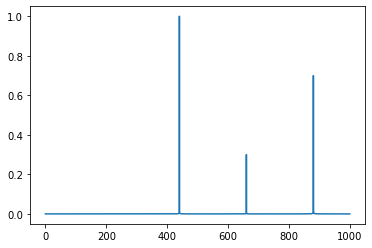

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd
import soundfile as sd

fs = 44100
t = np.linspace(0, 2, 2*fs)
señal = np.cos(2*np.pi*440*t) + 0.3 * np.cos(2*np.pi*660*t) +  0.7 *np.cos(2*np.pi*880*t)

fft_frecs = np.fft.rfftfreq(len(señal), 1/fs)
fft = abs(np.fft.rfft(señal))
fft /= max(fft)

plt.plot(fft_frecs[0:2000], fft[0:2000])
plt.show()

Así se escucha la suma de estos tonos.

In [26]:
ipd.Audio(señal, rate=fs)

La velocidad en la que cambia c en función de la frecuencia se denomina velocidad de fase y varía dependiendo del medio. Pero la energía de la onda sigue siendo continua y es lo que se denomina velocidad de grupo. Hay que mencionar que en este caso estamos haciendo variar la velocidad de propagación, pero también se denominan ondas dispersivas si varían otros parámetros de la onda como la fase, la amplitud o la longitud de onda.

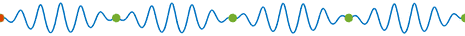

In [27]:
from IPython.display import Image
Image("Wave_group.gif")

En rojo  es la  velocidad fase de la onda y en verde la velocidad de grupo. Para este ejemplo voy a definir un cambio lineal que valla desde 0 hasta 350 m/s para las primeras 2000hz.

Text(0, 0.5, 'Velocidad (m/s)')

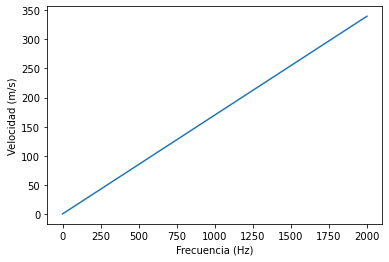

In [28]:
f = np.arange(0,2000)
c_f =  f * 0.17 

plt.plot(c_f)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Velocidad (m/s)')

Ahora establecemos una distancia a la cual vamos a posicionar la recepción del sonido, como ya explicamos en el caso no dispersivo esto va a significar simplemente un delay al principio del audio equivalente al tiempo que tarde en llegar el sonido desde la fuente hasta el receptor. En cambio, en el caso dispersivo lo que esperamos ver es la diferencia de arribo de los distintos tonos, siguiendo la relación lineal que establecimos donde los tonos más agudos llegarían más rápido.

En el caso común como c es cte, entonces $$c\cdot t=d $$

Pero en el caso dispersivo como c varía analizamos $$c(f)\cdot t=d $$

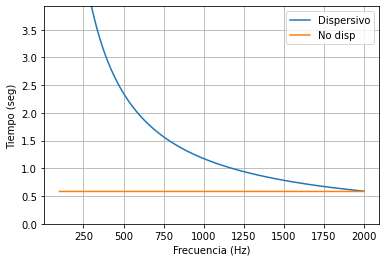

In [29]:
distancia = 200  #metros
c = 343  #m/s

tiempo_no_disp = distancia/c

c_f[0] = .0001
tiempo_disp = distancia/c_f

plt.plot(f[100:], tiempo_disp[100:], label='Dispersivo')
plt.plot(f[100:], np.ones(len(f[100:]))*tiempo_no_disp, label='No disp')
plt.ylim(0,tiempo_disp[300])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Tiempo (seg)')
plt.legend()
plt.grid()

En el gráfico se ve que en el caso no dispersivo vamos a escuchar un delay de 0.5 seg aproximadamente. En cambio en el caso disperviso el tiempo de arribo varia con la frecuencia. 

In [30]:
audio_no_disp = np.hstack([np.zeros(int(fs*tiempo_no_disp)), señal])
ipd.Audio(audio_no_disp, rate=fs)

Cuando se habla de disperción se plantea el siguiente gráfico que vincula w (frecuencia angular) y k(número de onda). En esta relación si c es constante, el gráfico es lineal donde c es la pendiente de la relación: $$ w = c\cdot k$$.

Si buscan ejemplos en materiales reales, en general las relación de dispersividad viene dada por esa relación en lo que se denomina cuerva dipersiva. Donde por ejemplo una relación no lineal puede ser la siguiente: $$ w = c \cdot k^2$$

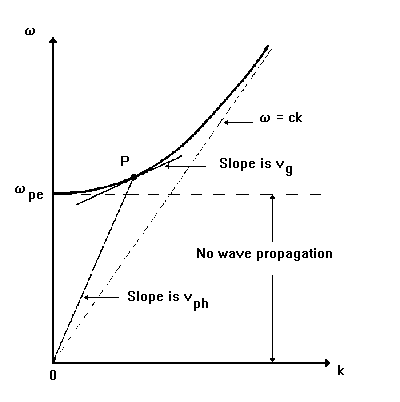

In [31]:
from IPython.display import Image
Image("c_k.gif")

Sabemos que nuestro sonido esta compuesto por frecuencias de 440hz que en la gráfico corresponde a un retraso de 2seg aproximadamente, vamos a realizar el procedimiento manual y después vamos a ver como optimizarlo para poder extrapolar nuestro procedimiento a sonidos más complejos.

In [32]:
frecs = [440,660,880]
audios = []
for f in frecs:
    audios.append(np.hstack([np.zeros(int(fs*tiempo_disp[f])),  np.cos(2*np.pi*f*t)])) #  fft[2*f] * np.cos
for i in range(1,len(audios)):    
    audios[i] = np.hstack([audios[i], np.zeros(len(audios[0])- len(audios[i]))])

audio_final = sum(audios)
ipd.Audio(audio_final, rate=fs)

Vamos a visulizar el espectograma de estas dos señales.

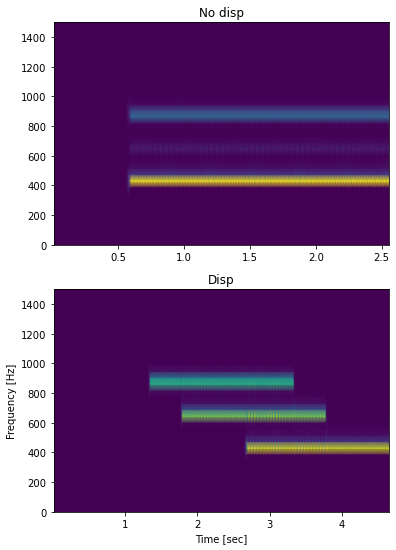

In [33]:
plt.subplot(211)
f, t, Sxx = signal.spectrogram(audio_no_disp, fs, nperseg=256*4)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title('No disp')
plt.ylim(0,1500)

plt.subplot(212)
f, t, Sxx = signal.spectrogram(audio_final, fs, nperseg=256*4)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title('Disp')
plt.ylim(0,1500)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplots_adjust(top=2)
plt.subplots_adjust(bottom=0.3)

Con el espectograma comporbamos que los tiempos de delay son los correctos.

Para aplicar este procedimiento a la señal de audio donde no sepamos la frecuencia, osea a un audio aleatorio, vamos a hacer un ventaneo de la señal en tiempo y aplicandole un filtro pasa banda, por ahora definí la distancia de  las ventanas de manera lineal, tendría que probar como se comporta con una subdivisión exponencial. El esquema es el siguiente:

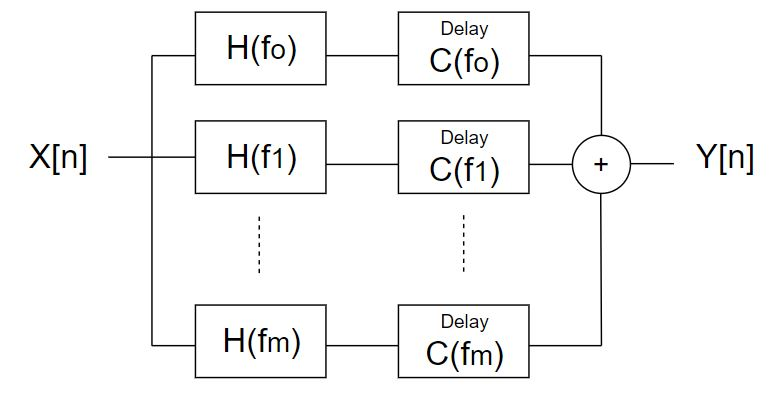

In [34]:
from IPython.display import Image
Image("diagrama.jpg")

In [35]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], analog=False,
        btype='band', output='sos')
    return sos

def third_bands_border(bands):
    bordes = []
    for i in range(len(bands)):
        bordes.append([bands[i] * 2 ** (-1/6), bands[i] * 2 ** (1/6)])
    return bordes

def padding(suma_audios, nuevo_audio):
    output = 0
    if len(suma_audios) == 0:
        output = nuevo_audio
        
    if len(nuevo_audio) < len(suma_audios):
        greater_len = len(suma_audios)
        nuevo_audio = np.hstack([nuevo_audio, np.zeros(greater_len - len(nuevo_audio))])
        output = nuevo_audio + suma_audios
        
    if len(nuevo_audio) > len(suma_audios):
        greater_len = len(nuevo_audio)
        suma_audios = np.hstack([suma_audios, np.zeros(greater_len - len(suma_audios))])
        output = nuevo_audio + suma_audios
    
    if len(nuevo_audio) == len(suma_audios):
        output = nuevo_audio + suma_audios
    
    return output

def index_f(bandas, fs):
    for i in range(len(bandas)):
        if bandas[i][1] > fs/2:
            return i - 2
    return len(bandas) - 1

In [36]:
frecs_bandas = [25 + 25 * i for i in range(80)]
frecs_borde = third_bands_border(frecs_bandas)
suma_audios = []

for i in range(len(frecs_bandas)-1):
    sos = butter_bandpass(frecs_borde[i][0],frecs_borde[i][1], fs)
    y = signal.sosfilt(sos, señal)
    audio_filt = np.hstack([np.zeros(int(fs * tiempo_disp[frecs_bandas[i]])), y])
    
    suma_audios = padding(suma_audios, audio_filt)

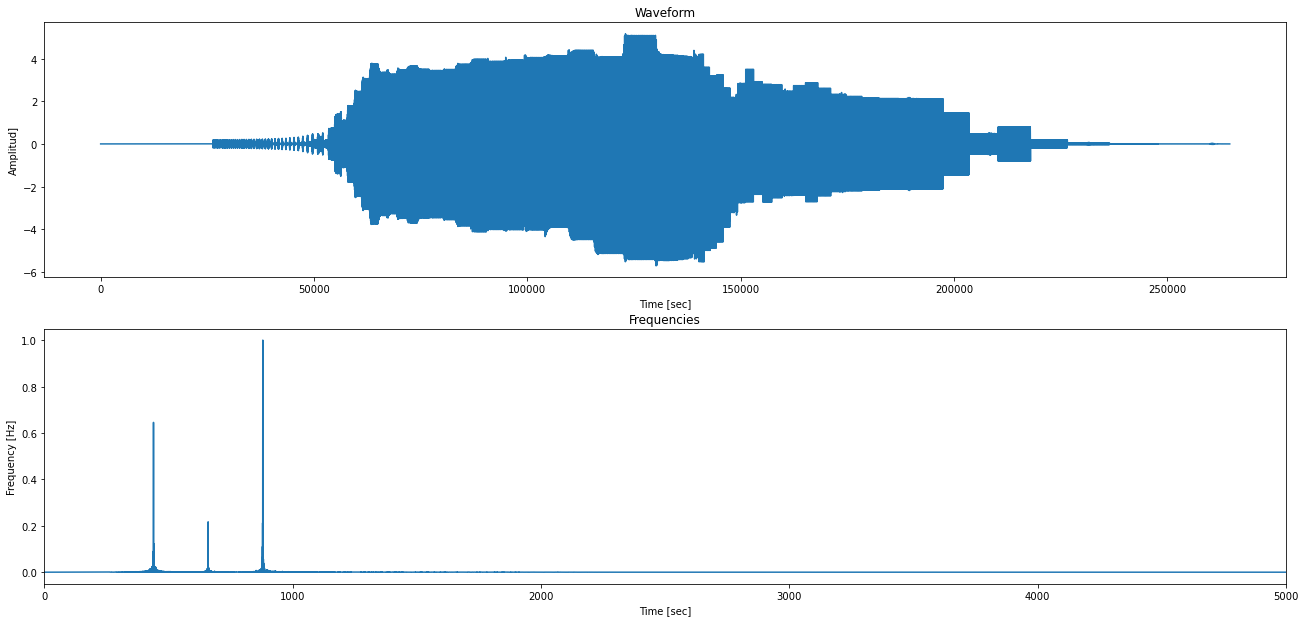

In [37]:
plt.subplot(211)
plt.plot(suma_audios[:44100*6])
plt.title('Waveform')
plt.ylabel('Amplitud]')
plt.xlabel('Time [sec]')

plt.subplot(212)
fft_frecs = np.fft.rfftfreq(len(suma_audios), 1/fs)
fft = abs(np.fft.rfft(suma_audios))
fft /= max(fft)

plt.plot(fft_frecs, fft)
plt.title('Frequencies')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.xlim(0,5000)
plt.subplots_adjust(top=2, right=3,bottom=0.05, wspace=0.2)

Esta es la señal construida a partir de retrasar la señal mediante filtros. Se ve con este proceso se crea una reconstrucción aproximada de la señal debido al ventaneo. Para mejorar esto tendría que aplicar algún tipo de suavizado a cada ventana para que la suma de este proceso no cree saltos abruptos en la señal. (Tengo que hacerlo)

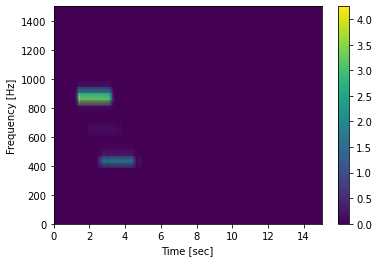

In [38]:
f, t, Sxx = signal.spectrogram(suma_audios, fs, nperseg=256 *4,scaling='spectrum')
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylim(0,1500)
plt.xlim(0,15)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

In [39]:
suma_audios /= max(suma_audios)
suma_audios = suma_audios[:44100*7]
ipd.Audio(suma_audios, rate=fs)

Se puede apreciar que la idea general se mantiene, aunque la calidad baja, es decir que el algoritmo cumple con lo esperado. Lo que no se cómo explicar es la diferencia en amplitud de las componentes frecuenciales. Por lo que entiendo eso no debería variar, pero se ve tanto en el plot del fft como en el espectrograma que la frecuencia que tiene más intensidad es la de mayor frecuencia y en el audio original era la de menor frecuencia la que tenía mayor intensidad. (Tengo que ver porque pasa esto).

Ahora vamos a tratar de aplicar esto a una señal real, en el primer test uso una intro de piano.

In [40]:
audio, fs = sd.read('audio_mono.wav')
audio = audio[0:44100 * 3]
ipd.Audio(audio, rate=fs)

Obtengo los parametros para hacer el analisis. La ventana al bajarla me da mas precision pero consume mas recursos, si después hago una subdivision temporal hay que manejar los dos parametros.

In [41]:
vel_decaimiento_cf = 0.1
distancia = 100
ancho_ventana_f = 200

new_f = np.arange(1, int(fs/2))
new_c_f = new_f * vel_decaimiento_cf
tiempo_disp = distancia/new_c_f

iteraciones_f = ((fs//2)//ancho_ventana_f)
frecs_bandas = [ancho_ventana_f + ancho_ventana_f * i for i in range(iteraciones_f - 1)]
frecs_borde = third_bands_border(frecs_bandas)

In [42]:
def disp_audio(audio, frecs_bandas, frecs_borde, fs):
    
    suma_audios = []

    for i in range(index_f(frecs_borde, fs)):  #Aca chequear que los bordes esten bien (no pasarse)
        sos = butter_bandpass(frecs_borde[i][0],frecs_borde[i][1], fs)
        y = signal.sosfilt(sos, audio)  #Cambio audio por señal y tengo lo de arriba con mas resolución
        audio_filt = np.hstack([np.zeros(int(fs * tiempo_disp[frecs_bandas[i]])), y])

        suma_audios = padding(suma_audios, audio_filt)
        
    return suma_audios

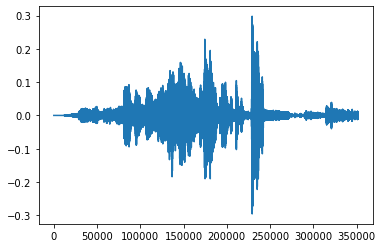

In [43]:
audio_piano = disp_audio(audio, frecs_bandas, frecs_borde, fs)

plt.plot(audio_piano)

In [44]:
ipd.Audio(audio_piano, rate=fs)

Se puede apreciar el concepto del sonido original pero se escucha como las frecuencias graves son las últimas en llegar. Un punto a tener en cuenta acá es que estoy considerando el filtro para dividir en frecuencias, pero integro en base a la señal en todo el tiempo, tendría que aplicar un ventaneo temporal también. Esto trae sus dificultades por la relación de dependencia entre la precisión entre tiempo y frecuencia, pero creo que para este caso con ventanas grandes en tiempo sería suficiente para generar un sonido que simule con precisión el estudio hipotético de ondas acústicas dispersivas.

Test con voz humana.

In [45]:
audio2, fs = sd.read('audio_mono_2.wav')
ipd.Audio(audio2, rate=fs)

In [46]:
audio_voz = disp_audio(audio2, frecs_bandas, frecs_borde, fs)

ipd.Audio(audio_voz, rate=fs)

Test voz español. Use una frase que tenga todas las letras del abecedario así contiene mas variación de frecuencias.

In [47]:
audio_voz_esp, fs = sd.read('Test Voz.wav')
ipd.Audio(audio_voz_esp, rate=fs)

In [48]:
audio_voz_esp_disp = disp_audio(audio_voz_esp, frecs_bandas, frecs_borde, fs)

ipd.Audio(audio_voz_esp_disp, rate=fs)

Aplico el mismo proceso pero ventaneando en tiempo. Va a escalar el tiempo del algoritmo a un O(N^2).

In [49]:
div_ventana = 10
ventana_t = len(audio2)//div_ventana
final_audio = []

for t in range(div_ventana):
    audio_t = disp_audio(audio2[t * ventana_t: (t+1) * ventana_t], frecs_bandas, frecs_borde, fs)
    
    if t >= 1:
        audio_t = np.hstack([np.zeros(t * ventana_t), audio_t])
        
    final_audio = padding(final_audio, audio_t)
    
ipd.Audio(final_audio, rate=fs)

Se puede escuchar como aparece como un delay de la señal que ya escuchamos previamente ya que ahora la diferencia de tiempo en la señal marca una diferencia de arribo entre frecuencias.

In [50]:
np.sqrt( (final_audio[fs*3] - audio_voz[fs*3])**2/(fs*3) )

9.988818868246669e-11

Un dato curioso es que los sonidos de disparos de las primeras películas de Star Wars fueron hechos grabando el sonido de un golpe en una pieza de metal y grabando el sonido que llega al final. Como el sonido que se transmite a través del metal es dispersivo las frecuencias agudas llegan antes y genera el sonido característico de la saga.

In [51]:
vel_decaimiento_cf = 0.1
distancia = 10
ancho_ventana_f = 100

new_f = np.arange(1, int(fs/2))
new_c_f = new_f * vel_decaimiento_cf
tiempo_disp = distancia/new_c_f

iteraciones_f = ((fs//2)//ancho_ventana_f)
frecs_bandas = [ancho_ventana_f + ancho_ventana_f * i for i in range(iteraciones_f - 1)]
frecs_borde = third_bands_border(frecs_bandas)

In [52]:
audio3, fs = sd.read('hammer.wav')
ipd.Audio(audio3, rate=fs)

In [53]:
audio_star_wars = disp_audio(audio3, frecs_bandas, frecs_borde, fs)

ipd.Audio(audio_star_wars, rate=fs)